<a href="https://colab.research.google.com/github/JacksonKerr/LinearRegression/blob/main/PCA_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFO204 Assignment 2
---
*Jackson Kerr | 2942576*

[GitHub Repo](https://github.com/JacksonKerr/LinearRegression)

---



#### Doc Options:

In [71]:
# If true, get graph images from GitHub repo instead (why is the pairplot function is so slow?!?!)
fast = True

if fast:
  from IPython.display import Image
  from IPython.core.display import HTML

## Helper functions from labs
- extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC')
- biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None)

In [72]:
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    """
       take a PCA model and extract its loadings into a data frame for easier interrogation
    """
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

In [73]:
def biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None):
    """
      plot two principal components of data embedded via PCA along with their feature loadings
    """
    xs = X[:, pc1]
    ys = X[:, pc2]
    
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())    
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=y, palette='viridis')
    
    if loadings is not None:
        n = len(loadings)
        if labels is None:
            labels = loadings.index.values
        for i in range(n):
            plt.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2], color='#ce2227', width=0.01, head_width=0.04)
            plt.text(loadings.iloc[i, pc1]* 1.15, loadings.iloc[i, pc2] * 1.15, labels[i], color='#ce2227', ha='center', va='center')
        
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.grid()

In [74]:
def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    """
        produce a plot from a PCA embedding that visualises the amount of 
        explained variance for each of the principal components 
    """
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()

##Gettin That Data:
Let's start by importing the wine data.

In [75]:
from sklearn.datasets import load_wine
import pandas as pd

wine_data = load_wine()

# Features
wine_x = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])

# Target
wine_y = wine_data['target']

# Features with target included
wine = wine_x.copy()
wine['target'] = wine_y.copy();

## Exploratory Data Analysis

#### Description:
Let's have a high level look at the data.

In [76]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

13 features plus the target. All inputs are decimal 64 bit floats. No null/missing values.

In [77]:
classes = list(set(wine['target']))
classes

[0, 1, 2]

The target only contains 3 unique values. This is likely an encoding for a three classes.

In [78]:
wine['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

Slight imbalance in occurances of each class, not too dramatic but may need to take this into account when modeling. Using KFold will help with this.

In [79]:
wine_x.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


There are large differences between the standard deviations of some features. Standardisation is likely to be useful when doing PCA. I will use standardisation in all cases as it rarely hurts but can bring inprovements.

Let's look at the relationships between the variables using hue="target".

In [80]:
import seaborn as sns
import numpy as np

if fast: 
  # Get stored pairplot from GitHub repo
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/resources/wine_data_pairplot.png")
else: img = sns.pairplot(wine, hue='target')
img


Good grouping going on for many variables. Won't look at removing correlated features, etc as we have PCA to do the work for us.

## PCA

Let's start with by using sklearn's PCA library without any cross validation and using default params.

In [81]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline

pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
P = pipe.fit_transform(wine_x)
pca_frame = pd.DataFrame(P, columns=[ f'PC{i+1}' for i in range(len(wine_data['feature_names'])) ])
pca_frame['target'] = wine_y

### Pairplot

In [82]:
if fast: 
  # Get stored pairplot from GitHub repo 
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/resources/pca_pairplot.png")
else: img = sns.pairplot(pca_frame, hue='target')
img

### Loadings:

In [83]:
# Loadings
display(extract_loadings(pca, feature_names=wine_data['feature_names']))

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcohol,0.144329,-0.483652,-0.207383,-0.017856,-0.265664,-0.213539,-0.056396,-0.396139,0.508619,0.211605,-0.225917,-0.266286,0.014970
malic_acid,-0.245188,-0.224931,0.089013,0.536890,0.035214,-0.536814,0.420524,-0.065827,-0.075283,-0.309080,0.076486,0.121696,0.025964
ash,-0.002051,-0.316069,0.626224,-0.214176,-0.143025,-0.154475,-0.149171,0.170260,-0.307694,-0.027125,-0.498691,-0.049622,-0.141218
alcalinity_of_ash,-0.239320,0.010591,0.612080,0.060859,0.066103,0.100825,-0.286969,-0.427970,0.200449,0.052799,0.479314,-0.055743,0.091683
magnesium,0.141992,-0.299634,0.130757,-0.351797,0.727049,-0.038144,0.322883,0.156361,0.271403,0.067870,0.071289,0.062220,0.056774
total_phenols,0.394661,-0.065040,0.146179,0.198068,-0.149318,0.084122,-0.027925,0.405934,0.286035,-0.320131,0.304341,-0.303882,-0.463908
flavanoids,0.422934,0.003360,0.150682,0.152295,-0.109026,0.018920,-0.060685,0.187245,0.049578,-0.163151,-0.025694,-0.042899,0.832257
nonflavanoid_phenols,-0.298533,-0.028779,0.170368,-0.203301,-0.500703,0.258594,0.595447,0.233285,0.195501,0.215535,0.116896,0.042352,0.114040
proanthocyanins,0.313429,-0.039302,0.149454,0.399057,0.136860,0.533795,0.372139,-0.368227,-0.209145,0.134184,-0.237363,-0.095553,-0.116917
color_intensity,-0.088617,-0.529996,-0.137306,0.065926,-0.076437,0.418644,-0.227712,0.033797,0.056218,-0.290775,0.031839,0.604222,-0.011993


### Screeplot:

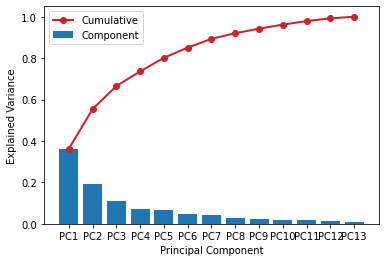

In [84]:
screeplot(pca)

Looks like we're getting to 80% accuracy with around 5 principal components.

### Biplot:

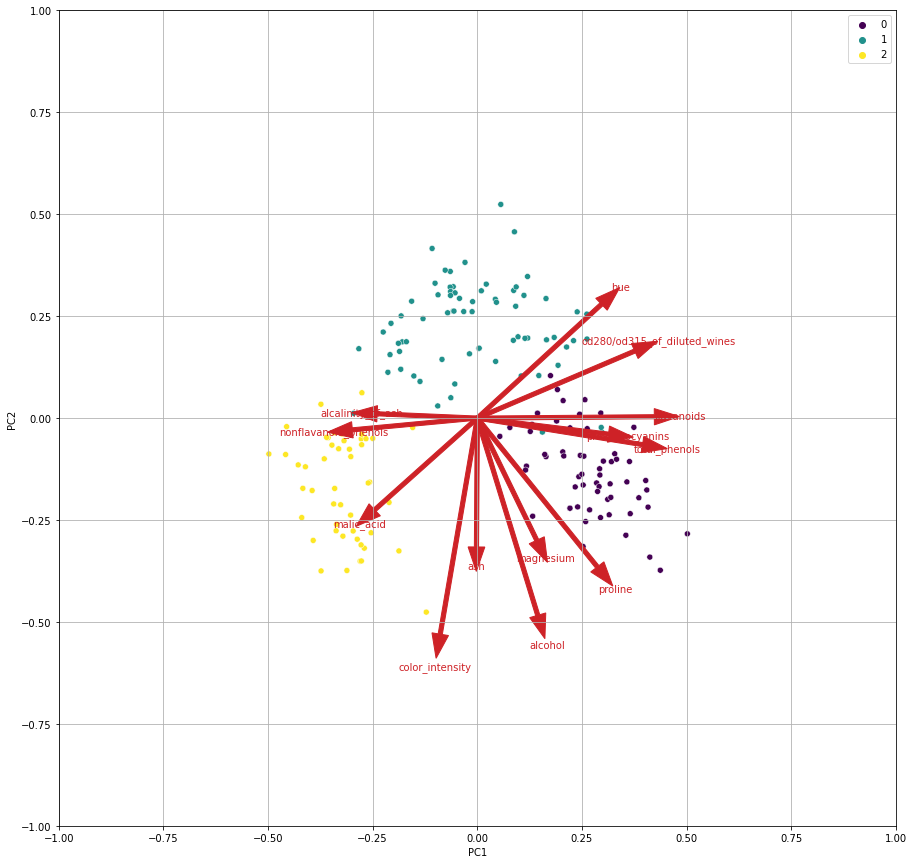

In [85]:
# Biplot
fig = plt.figure(figsize=(15, 15))
biplot(P, extract_loadings(pca, feature_names=wine_data['feature_names']), y=wine_y)
plt.show()

Based on the plot above, we are likely to have an easy time classifying class2 from class0 and class1. However, there is some overlap between class0 and class1 meaning our models may have some trouble telling them apart.

We can wee some correlations that were hinted at in the pairplot, namely between:
- Proanthocyanins and total_phenols
- Alcalinity_of_ash and nonflavanoid_phenols

As PCA1 mainly depends on flavanoids and PCA2 mainly depends on ash, we would expect these to be the best features for use in estimation and result in the best segregations of the classes.


## Cross validation and Model Comparison

### Imports and helper methods

In [86]:
# We'll need these
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=10, n_repeats=3) # 3 ROUNDS and 10 FOLDS

In [87]:
# Evaluates a model, returning the mean test score
def cross_val_eval(pipe, x, y):
  cv = cross_val_score(pipe, x, y, cv=rkf)
  return sum(cv) / len(cv)

### Cross validation analysis of Logistic Regression for each pair of features

In [88]:
def get_feature_name_pairs(frame):
  pairs = []
  f_names = list(frame.keys())
  for i in range(len(f_names)):
    for j in range(len(f_names)):
      if (f_names[i] >= f_names[j]): continue # Avoids repeats and repeats with swapped ordering
      else: pairs.append([f_names[i], f_names[j]])
  return pairs

from tqdm import tqdm # Progress bar because this takes a while
feature_pairs_performance = []
pipe = Pipeline([("scale", StandardScaler()), ("log_reg", LogisticRegression())])
for features in tqdm(get_feature_name_pairs(wine_x)):
  feature_pairs_performance.append([features[0], features[1],
                                    cross_val_eval(pipe, wine_x.loc[:, features], wine_y)])

100%|██████████| 78/78 [00:25<00:00,  3.04it/s]


### Cross validation analysis of logistic regression using the first two principal compoenents

In [89]:
pipe = Pipeline([("scale", StandardScaler()), ('pca', PCA(n_components=2)), ("log_reg", LogisticRegression())])
pc2_accurary = cross_val_eval(pipe, wine_x, wine_y)

### Determining ideal number of principal components using cross validation

In [90]:
def cross_val_optimal_pca_components():
  pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA()), ("log_reg", LogisticRegression())])
  param_grid = { 'pca__n_components' : [i for i in range(1, len(wine_data['feature_names']))] }
  cv = GridSearchCV(pipe, param_grid=param_grid, cv=rkf).fit(wine_x, wine_y)
  results = cv.cv_results_['mean_test_score']
  return cv.best_params_['pca__n_components'], cv.cv_results_['mean_test_score']
optimal_components, pca_scores = cross_val_optimal_pca_components()

In [91]:
# 4/5/7
og_features_accuracy = cross_val_eval(
    Pipeline([('Scale', StandardScaler()), ('log_reg', LogisticRegression())]), wine_x, wine_y)

from tabulate import tabulate
print("=========== Logistic Regression ===========")
table = [['2 Principal Components', round(pc2_accurary, 5)],
         ['2 Best original features', round(max(feature_pairs_performance, key=lambda x:x[2])[2], 5)],
         ['All original features', round(og_features_accuracy, 5)],
         [str(optimal_components) + " Principal Components (Optimal)", round(max(pca_scores), 5)]]
print(tabulate(table, headers=['Training Data', 'Accuracy']))
# print("Winner is", max(table, key=lambda x:x[1]))


=========== Logistic Regression ===========
Training Data                       Accuracy
--------------------------------  ----------
2 Principal Components               0.95697
2 Best original features             0.91961
All original features                0.98333
9 Principal Components (Optimal)     0.98497


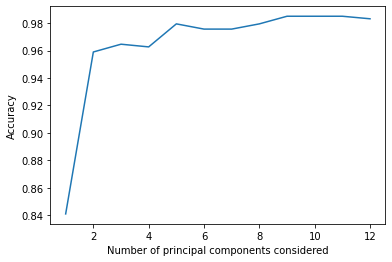

In [92]:
# 6
plt = sns.lineplot(x=[i for i in range(1, len(pca_scores)+1)], y=pca_scores)
plt.set(xlabel='Number of principal components considered', ylabel='Accuracy')
display(plt)

In [93]:
# 8
# If the number of components selected is less than the number of features in the original data, this
# suggests that some of the features of the data were not correlated with the target and therefore
# are not useful for predictions of the target

# Part 2

In [94]:
# 1 
# Bias refers to the inability of a model to capture the true relationship in the data whereas 
# variance refers to overfitting; where the model is partially modeling noise.

In [95]:
# 2
# Ensemble learning works by forming an ensemble of learners and somehow combining their predictions.
# As a result, the random error in their answers will average to zero provided we use enough of them.

In [96]:
# 3

# Bagging:

# Boosting:


In [97]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

boston = load_boston()
X = boston['data']
y = boston['target']
feature_names = boston['feature_names']

## ignore this - this is just to have something to call in the loop!
def eval_dummy(X_train, y_train, X_test, y_test):
    return mean_squared_error(y_test, DummyRegressor().fit(X_train, y_train).predict(X_test))

For the decomposition, we need a fixed test set (so that we can easily determine the _average_ prediction)

Obtain two sets from the original data - one for testing and one for further sampling of training sets (we'll call this the _learning_ set)

In [98]:
X_learn, X_test, y_learn, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
M = [ train_test_split(X_learn, y_learn, train_size=0.5, random_state=state) for state in range(100) ]

In [99]:
# Based on code from lab 10
def bias_var_decomp(model_generator, M, h_param_name, h_param_range):
  res = []
  for (X_train, _, y_train, _) in tqdm(M):
    for h_param in h_param_range:
      mdl = model_generator(**{h_param_name : h_param}).fit(X_train, y_train)
      y_pred = mdl.predict(X_test)
      for i, y in enumerate(y_pred):
          res.append({ 'param' : h_param, 'i' : i, 't' : y_test[i], 'y' : y })

  # Plot mse, bias, and variance against eachother (Stolen from lab 10)
  res = pd.DataFrame(res)
  ybar = res.groupby([ 'param', 'i' ]).agg(ybar=('y', 'mean')).reset_index()
  decomp = pd.merge(res, ybar, how='inner')
  decomp['mse'] = (decomp['t'] - decomp['y'])**2
  decomp['bias'] = (decomp['t'] - decomp['ybar'])**2
  decomp['var'] = (decomp['y'] - decomp['ybar'])**2
  decomp = decomp.groupby('param').agg({ 'mse' : np.mean, 'bias' : np.mean, 'var' : np.mean }).reset_index().melt(id_vars='param') ## Step 6
  sns.lineplot(data=decomp, x='param', y='value', hue='variable');

100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


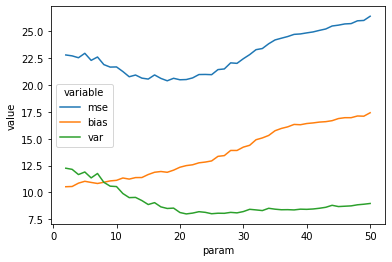

In [100]:
# 4
from sklearn.tree import DecisionTreeRegressor
bias_var_decomp(DecisionTreeRegressor, M, 'min_samples_split', range(2, 51))

100%|██████████| 100/100 [04:37<00:00,  2.78s/it]


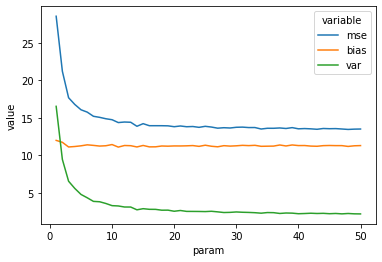

In [101]:
# 5
from sklearn.ensemble import RandomForestRegressor
bias_var_decomp(RandomForestRegressor, M, 'n_estimators', range(1, 51))

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


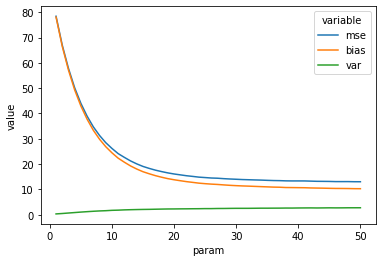

In [102]:
# 6
from sklearn.ensemble import GradientBoostingRegressor
bias_var_decomp(GradientBoostingRegressor, M, 'n_estimators', range(1, 51))

In [103]:
# 7